<a href="https://colab.research.google.com/github/suchy1713/EmotionPredicition/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://raw.githubusercontent.com/suchy1713/EmotionPredicition/master/data/preprocessed/data.csv')
data = df.values
X = data[:, :11]
y = data[:, 11:].argmax(axis=1)

We are going to evaluate our models using cross validation. We considered using just training and test sets but it turned out that the dataset is not too big and CV is not taking too long. We will also measure learning time as it might help us with final choice of the best model.

For hyperparameter tuning we decided to go with grid search to automatize this process just a little bit.

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import time
import seaborn as sns
import matplotlib.pyplot as plt

def get_performance(model, X, y):
    start = time.time()
    score = np.mean(cross_val_score(model, X, y, cv=5))
    end = time.time()

    return score, end-start

def find_best_params(model, X, y, params):
    grid = GridSearchCV(estimator=model, param_grid=params, verbose=10, n_jobs=-1)
    grid.fit(X, y)

    print('\n\nACCURACY: ', grid.best_score_)
    print('BEST PARAMS:', grid.best_params_)

def plot_model_comparison(accuracies, times, legend):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=accuracies, y=times, hue=legend, s=150)

    plt.title('Model performance comparison')
    plt.xlabel('Accuracy')
    plt.ylabel('Time')

For our first pass, we chose the widest range of models we could possibly think of:<br>
-> Logistic Regression<br>
-> Naive Bayes (probability based)<br>
-> Support Vector Classifier (distance based)<br>
-> Decision Tree<br>
-> Random Forest (tree ensemble)<br>
-> XG Boost (tree ensemble)<br>
-> Neural Network<br>

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

Let's compare their default versions. This step should let us eliminate the ones that definitely are not going to perform well on this type of data.

Logistic Regression  - Accuracy:  0.3925627240143369  Time:  2.585238218307495
Naive Bayes  - Accuracy:  0.3492831541218638  Time:  0.0481564998626709
Support Vector Machine  - Accuracy:  0.39874551971326166  Time:  27.475837230682373
Decision Tree  - Accuracy:  0.4198028673835125  Time:  0.08410239219665527
Random Forest  - Accuracy:  0.42034050179211474  Time:  3.1563358306884766
XG Boost  - Accuracy:  0.4141577060931899  Time:  7.393480539321899
Neural Network  - Accuracy:  0.4145161290322581  Time:  67.76044654846191


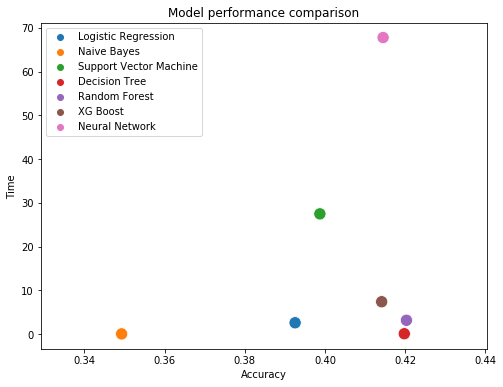

In [0]:
legend = ['Logistic Regression', 'Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'XG Boost', 'Neural Network']
models = [LogisticRegression(), GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), xgb.XGBClassifier(), MLPClassifier(max_iter=1000)]
times = []
accuracies = []

for model, name in zip(models, legend):
    a, t = get_performance(model, X, y)
    accuracies.append(a)
    times.append(t)
    print(name, ' - Accuracy: ', a, ' Time: ', t)

plot_model_comparison(accuracies, times, legend)

We can see there are two clear outliers - Naive Bayes and Neural Network. We will rule them out at this point. Naive Bayes works better with text data and in our case it simply cannot compete in terms of accuracy. Neural network, on the other hand, shines when it comes to non-tabular data. Given the very long learning time, we would expect it to be much more accurate than other models but thst's not the case. We won't even waste our time trying to tune it.

Now onto hyperparameter tuning:

Logistic Regression:<br>
1. C - inverse of regularization strength (smaller values specify stronger regularization)

In [0]:
brain = LogisticRegression()
c = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
params = dict(C = c)

find_best_params(brain, X, y, params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1250s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0160s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.4s finished




ACCURACY:  0.392831541218638
BEST PARAMS: {'C': 10.0}


Support Vector Classifier:
1. kernel - type of hyperplane used to separate the data
2. gamma - kernel coefficient; the higher the gamma the more exactly SVC is trying to fit to the training set
3. C - inverse of the regularization strength


In [0]:
brain = SVC()
kernels = ['linear', 'rbf', 'poly']
gammas = [0.001, 0.01, 0.1, 1]
c = [0.1, 1, 10]

params = dict(kernel=kernels, gamma=gammas, C=c)

find_best_params(brain, X, y, params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  7



ACCURACY:  0.4218637992831541
BEST PARAMS: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


Decision Tree:
1. max_depth - maximum tree depth
2. min_samples_split - the minimum number of samples required to split an internal node
3. min_samples_leaf - minimum number of samples required to be at a leaf node

In [0]:
brain = DecisionTreeClassifier()
max_depths = range(1, 33)
min_samples_splits = range(1, 11)
min_samples_leafs = range(1, 11)

params = dict(max_depth=max_depths, min_samples_split=min_samples_splits, min_samples_leaf=min_samples_leafs)

find_best_params(brain, X, y, params)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1932s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0307s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0410s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0697s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1386s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 358 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 646 tasks      | elapsed:    2.9s
[Parallel(n



ACCURACY:  0.425179211469534
BEST PARAMS: {'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 16000 out of 16000 | elapsed:  2.6min finished


Random Forest
1. n_estimators - the number of trees in the forest
2. max_depth - maximum tree depth
3. min_samples_split - the minimum number of samples required to split an internal node
4. min_samples_leaf - minimum number of samples required to be at a leaf node

For tree ensembles tuning we went with genetic algorithm. It produced results similar to grid search but turned out to be significantly faster.

In [9]:
from genetuning import GeneTuning, Param

brain = RandomForestClassifier()
params = dict(max_depth=Param(2, 18, step=2), min_samples_split=Param(2, 4), min_samples_leaf=Param(1, 8), n_estimators=Param(100, 1500, step=200))

gt = GeneTuning(RandomForestClassifier(), params, parents_num=4, children_num=4, population_size_init=20)
gt.fit(X, y)
print('\n\nACCURACY: ', gt.best_score)
print('BEST PARAMS:', gt.best_params)

Generation  1 / 4 :
Fitting model 1 / 20 :  {'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 2, 'n_estimators': 700}  : 0.31980286738351255
Fitting model 2 / 20 :  {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'n_estimators': 300}  : 0.432168458781362
Fitting model 3 / 20 :  {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 7, 'n_estimators': 900}  : 0.43405017921146954
Fitting model 4 / 20 :  {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 2, 'n_estimators': 1100}  : 0.31890681003584226
Fitting model 5 / 20 :  {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 500}  : 0.32096774193548383
Fitting model 6 / 20 :  {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 500}  : 0.4182795698924731
Fitting model 7 / 20 :  {'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 7, 'n_estimators': 500}  : 0.4285842293906811
Fitting model 8 / 20 :  {'max_depth': 12, 'min_samples_s

XG Boost
1. n_estimators - the number of trees to fit
2. max_depth - maximum tree depth
3. min_child_weight - minimum sum of weights needed in child
4. subsample - subsample ratio of the training instances (1 - train using all of the data, 0.5 - train using half of the data)
5. colsample_bytree - subsample ratio of columns used when constructing new tree
6. learning_rate - step size shrinkage used to prevent overfitting

In [10]:
from genetuning import GeneTuning, Param

brain = RandomForestClassifier()
params = dict(max_depth=Param(3, 8, step=2), 
              min_child_weight=Param(1, 8), 
              subsample=Param(0.5, 1, round_=2, is_integer=False), 
              colsample_bytree=Param(0.5, 1, round_=2, is_integer=False), 
              learning_rate=Param(0.01, 0.3, round_=3, is_integer=False),
              n_estimators=Param(50, 400, step=50))

gt = GeneTuning(xgb.XGBClassifier(objective='multi:softmax'), params, parents_num=4, children_num=4, population_size_init=20)
gt.fit(X, y)
print('\n\nACCURACY: ', gt.best_score)
print('BEST PARAMS:', gt.best_params)

Generation  1 / 4 :
Fitting model 1 / 20 :  {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.71, 'colsample_bytree': 0.71, 'learning_rate': 0.019, 'n_estimators': 300}  : 0.4360215053763441
Fitting model 2 / 20 :  {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.54, 'colsample_bytree': 0.67, 'learning_rate': 0.135, 'n_estimators': 300}  : 0.4291218637992832
Fitting model 3 / 20 :  {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.64, 'colsample_bytree': 0.52, 'learning_rate': 0.114, 'n_estimators': 100}  : 0.4195340501792115
Fitting model 4 / 20 :  {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.66, 'colsample_bytree': 0.76, 'learning_rate': 0.01, 'n_estimators': 350}  : 0.4171146953405017
Fitting model 5 / 20 :  {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 0.62, 'learning_rate': 0.071, 'n_estimators': 200}  : 0.43915770609318994
Fitting model 6 / 20 :  {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.63, 'colsample_bytree'

Now let's evaluate our tuned models and pick the best one:

Logistic Regression  - Accuracy:  0.392831541218638  Time:  2.7102038860321045
Support Vector Machine  - Accuracy:  0.4218637992831541  Time:  35.01674151420593
Decision Tree  - Accuracy:  0.425179211469534  Time:  0.08079409599304199
Random Forest  - Accuracy:  0.4353942652329749  Time:  19.118155241012573
XG Boost  - Accuracy:  0.439068100358423  Time:  18.07665514945984


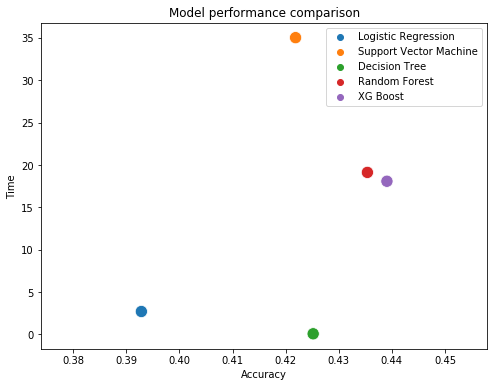

In [12]:
legend = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'XG Boost']
models = [LogisticRegression(C=10), 
          SVC(C=10, gamma=1, kernel='rbf'), 
          DecisionTreeClassifier(max_depth=14, min_samples_leaf=4, min_samples_split=2), 
          RandomForestClassifier(max_depth=12, min_samples_split=3, min_samples_leaf=5, n_estimators=700), 
          xgb.XGBClassifier(max_depth=3, min_child_weight=7, subsample=0.85, colsample_bytree=0.71, learning_rate=0.264, n_estimators=250)]
times = []
accuracies = []

for model, name in zip(models, legend):
    a, t = get_performance(model, X, y)
    accuracies.append(a)
    times.append(t)
    print(name, ' - Accuracy: ', a, ' Time: ', t)

plot_model_comparison(accuracies, times, legend)

The learning times for these algorithms and given amount of data are similar so we're going to make our choice based only on accuracy. And in that spirit, the best model for our task is XG Boost with parameters:
1. max_depth=3
2. min_child_weight=7
3. subsample=0.85
4. colsample_bytree=0.71
5. learning_rate=0.264
6. n_estimators=250

It is around 2.2 times more accurate than just making random prediction every time.